In [1]:
import instructor
from pydantic import BaseModel, Field
from openai import OpenAI
from enum import Enum
from typing import List
import pandas as pd
import os


In [2]:
# Define the path to the data folder, going up one directory
data_folder = os.path.join('..', 'data')


## Fake News Classification

In [3]:
# Read the .txt file into a DataFrame
fake_news = pd.read_csv(os.path.join(data_folder, 'fake_newss_1.txt'), delimiter=';', header=0)

In [4]:
fake_news

,Unnamed: 0,title,text,label
0,0,"Live from New York, it's a Trump-Clinton remat...",NEW YORK (Reuters) - Veteran actor and frequen...,1
1,1,Catalan separatists to lose majority in tight ...,BARCELONA (Reuters) - Catalonia s independence...,1
2,2,North Carolina governor concedes election to D...,"WINSTON-SALEM, N.C. (Reuters) - North Carolina...",1
3,3,Draft Senate Iran legislation sets tough new U...,WASHINGTON (Reuters) - Draft legislation respo...,1
4,4,California governor taps U.S. Representative B...,"SACRAMENTO, Calif. (Reuters) - California Gove...",1
...,...,...,...,...
8112,8112,Sanders at Vatican says rich-poor gap worse th...,VATICAN CITY (Reuters) - U.S. presidential can...,1
8113,8113,how trump happened,force and fanaticism wahhabism in saudi arabi...,1
8114,8114,Turkey will take two steps if Germany takes on...,"ISTANBUL (Reuters) - Turkey, whose relations w...",1
8115,8115,BREAKING: DEVICE THAT BUSTED HILLARY CLINTON D...,Here s why Clinton and Abedin should be flippi...,0


In [5]:
fake_news.iloc[:1000, :].label.value_counts()


label
1    535
0    465
Name: count, dtype: int64

### EDA

c:\Python311\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Python311\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Python311\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Python311\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Python311\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Python311\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palett

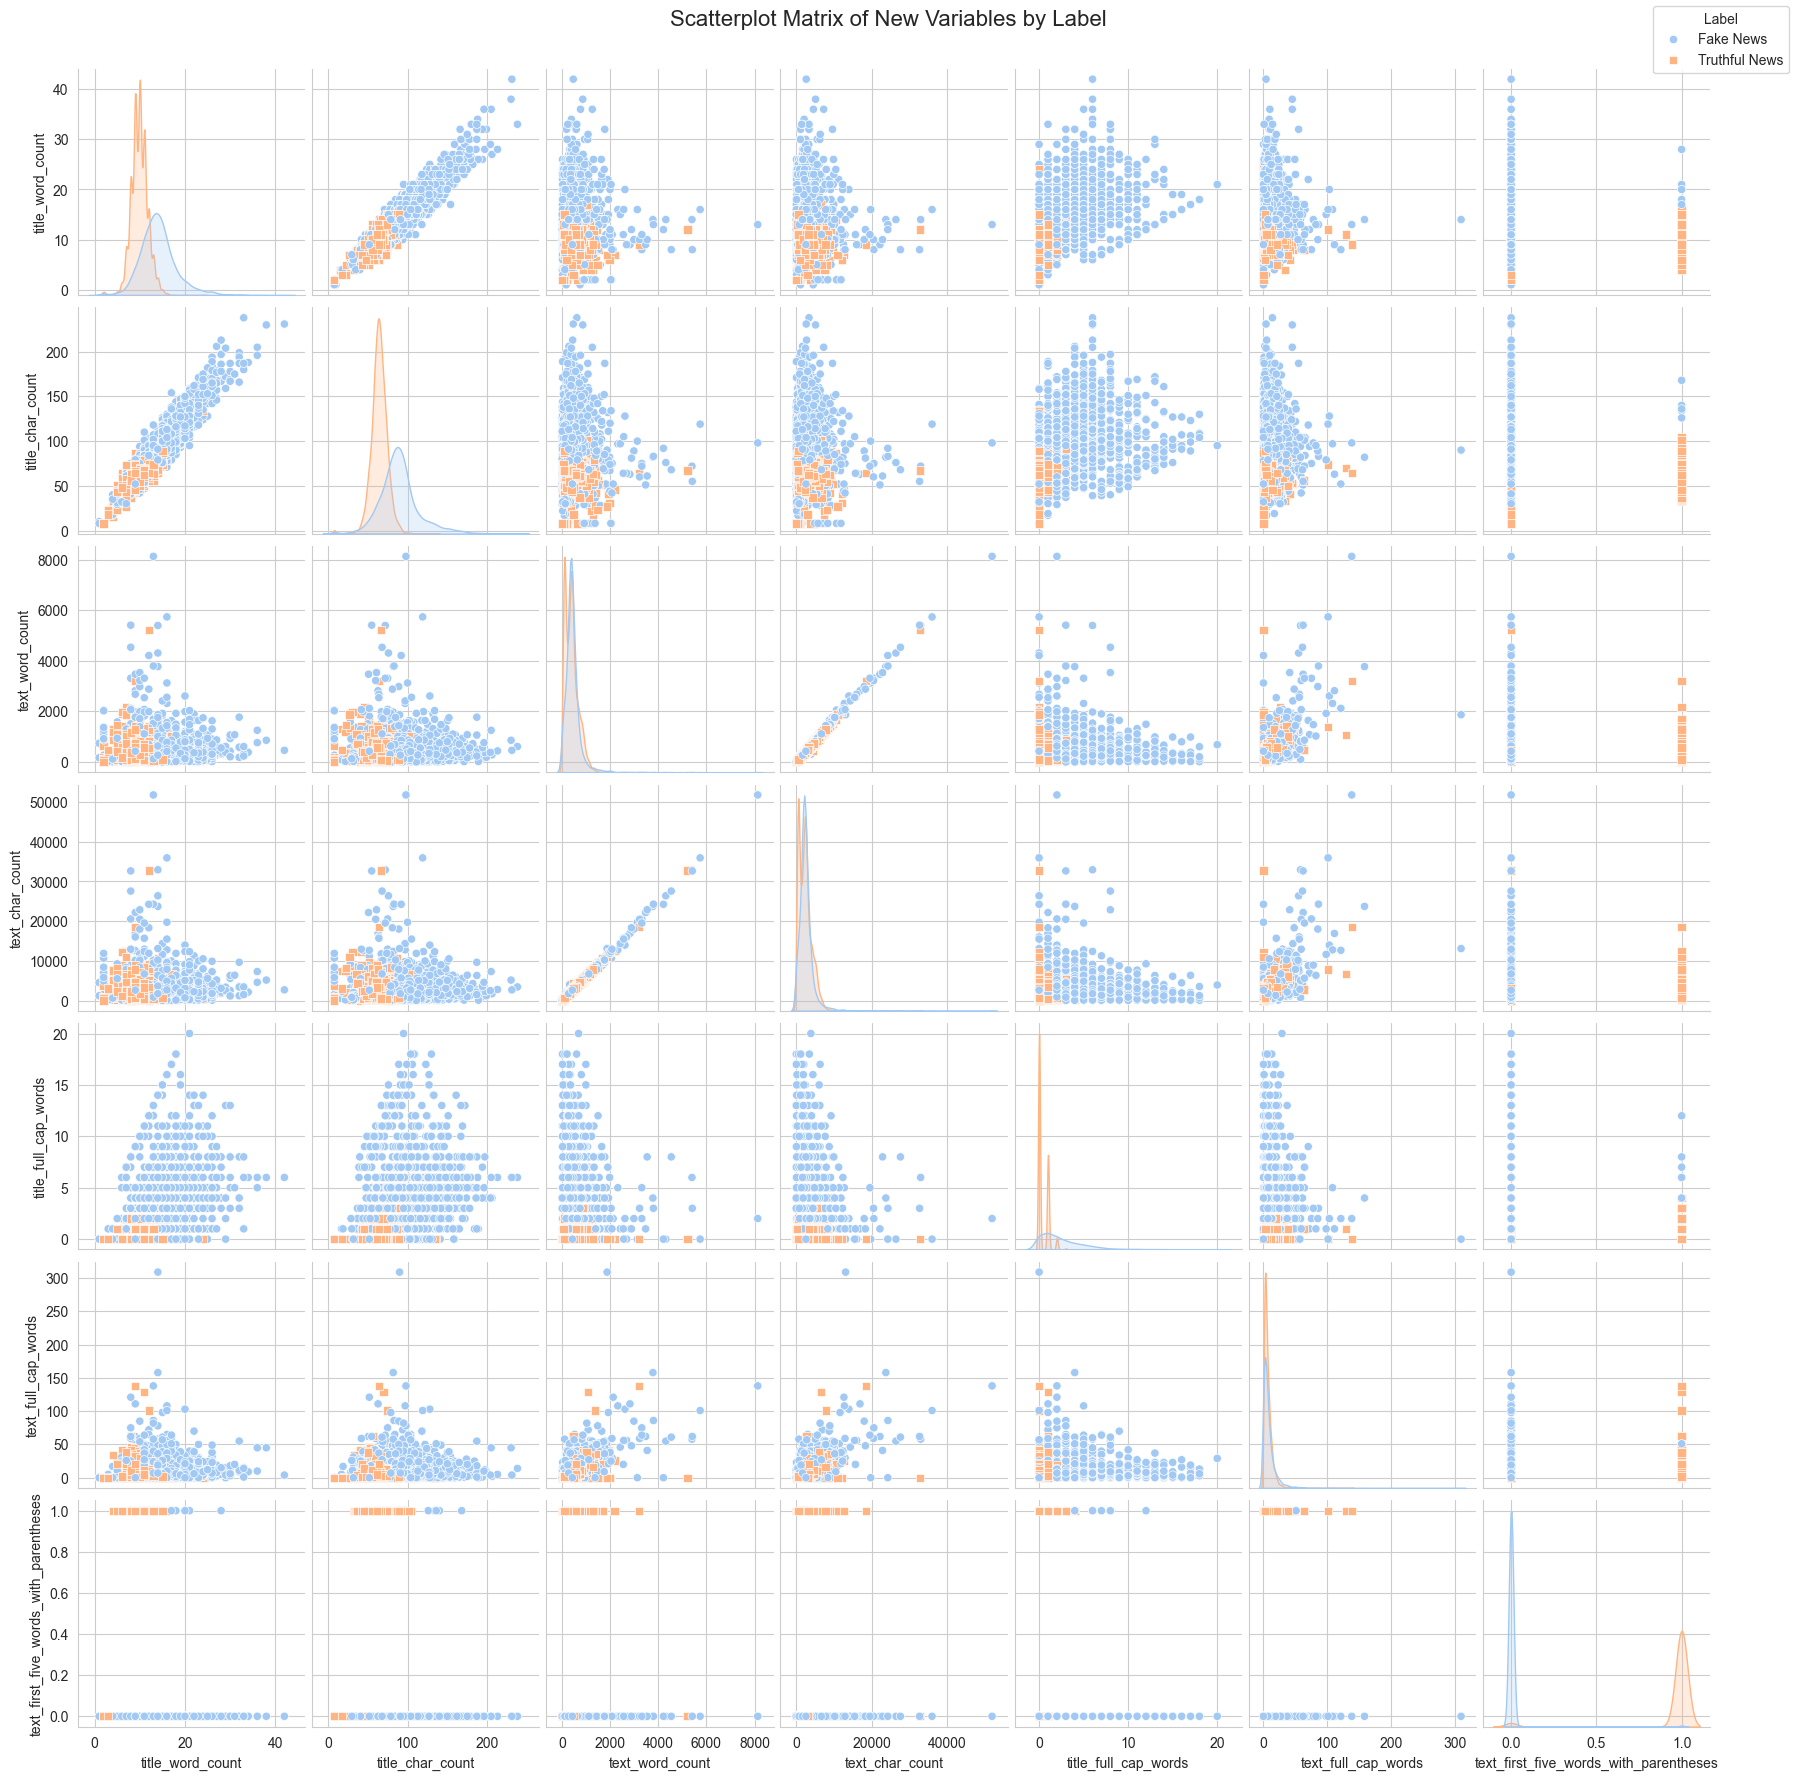

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for seaborn plots
sns.set_style("whitegrid")

# Create new columns for analysis (assuming fake_news DataFrame is already defined)
fake_news['title_word_count'] = fake_news['title'].apply(lambda x: len(str(x).split()))
fake_news['title_char_count'] = fake_news['title'].apply(lambda x: len(str(x)))
fake_news['text_word_count'] = fake_news['text'].apply(lambda x: len(str(x).split()))
fake_news['text_char_count'] = fake_news['text'].apply(lambda x: len(str(x)))

# Add new columns as per instructions
fake_news['title_full_cap_words'] = fake_news['title'].apply(lambda x: sum(1 for word in str(x).split() if word.isupper()))
fake_news['text_full_cap_words'] = fake_news['text'].apply(lambda x: sum(1 for word in str(x).split() if word.isupper()))
fake_news['text_first_five_words_with_parentheses'] = fake_news['text'].apply(lambda x: any('(' in word for word in str(x).split()[:5]))

# Set the pastel color palette
pastel_palette = sns.color_palette("pastel")

# Plot the scatterplot matrix
pair_plot = sns.pairplot(fake_news, 
                         vars=['title_word_count', 'title_char_count', 'text_word_count', 'text_char_count', 'title_full_cap_words', 'text_full_cap_words', 'text_first_five_words_with_parentheses'], 
                         hue='label', 
                         markers=['o', 's'], 
                         palette=pastel_palette)

# Update legend labels
handles, labels = pair_plot._legend_data.values(), pair_plot._legend_data.keys()
new_labels = ['Fake News' if label == '0' else 'Truthful News' for label in labels]

# Set new labels in the legend
for handle, new_label in zip(handles, new_labels):
    handle.set_label(new_label)

# Update the legend with new labels
pair_plot._legend.remove()  # Remove the old legend
pair_plot.fig.legend(handles, new_labels, title='Label', loc='upper right')  # Add new legend

# Set the title for the plot
plt.suptitle('Scatterplot Matrix of New Variables by Label', fontsize=16, y=1.02)

# Display the plot
plt.show()

### LLM Classification

In [7]:
# Initialize the OpenAI client
client = instructor.patch(OpenAI())

# Define the data model for classification
class FakeNewsCategory(str, Enum):
    FAKE_NEWS = "fake_news" # 1
    REAL_NEWS = "real_news" # 0

class FakeNewsClassification(BaseModel):
    category: FakeNewsCategory
    confidence: float = Field(ge=0, le=1, description="Confidence score for the classification")


In [8]:
SYSTEM_PROMPT = """
You are an AI assistant for a large customer support team. 
Here you are analyzing news and classifying them as fake or not fake.

You will be given the title and the text of the news.
You will be classifying the news as fake_news or real_news.

Pay attention to the title and the text of the news and to the source of the news, if provided.
Pay attention also to the formatting of the news and any clue that might give sign that it is fake news.
Articles that appeal to emotions, tend to be fake news. Articles that explain facts, tend to be not fake news.


Articles with a lot of capital letters are more likely to be fake news.
Articles with a word in the first five words of the text that starts with a parenthesis are more likely to be real news.
Example, when articles starts with WASHINGTON (Reuters) - is more likely to be real news.



Your tasks:
1. Categorize the ticket into the most appropriate category.
2. Provide a confidence score for the classification.

Remember:
- Be objective and base your analysis solely on the information provided in the ticket.
- If you're unsure about any aspect, reflect that in your confidence score.

Analyze the following customer support ticket and provide the requested information in the specified format.
"""

def classify_ticket(ticket_text: str) -> FakeNewsClassification:
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        response_model=FakeNewsClassification,
        temperature=0,
        max_retries=5,
        messages=[
            {
                "role": "system",
                "content": SYSTEM_PROMPT,
            },
            {"role": "user", "content": ticket_text}
        ]
    )
    return response

In [9]:
# Assuming fake_news DataFrame has 'title' and 'text' columns

# Create the 'article' column
fake_news['article'] = 'title: ' + fake_news['title'] + ' text: ' + fake_news['text']

In [10]:
subset = fake_news.iloc[:500, :]
subset.label.value_counts()

label
1    277
0    223
Name: count, dtype: int64

In [11]:
subset

,Unnamed: 0,title,text,label,title_word_count,title_char_count,text_word_count,text_char_count,title_full_cap_words,text_full_cap_words,text_first_five_words_with_parentheses,article
0,0,"Live from New York, it's a Trump-Clinton remat...",NEW YORK (Reuters) - Veteran actor and frequen...,1,11,59,363,2221,0,14,True,"title: Live from New York, it's a Trump-Clinto..."
1,1,Catalan separatists to lose majority in tight ...,BARCELONA (Reuters) - Catalonia s independence...,1,9,60,210,1281,0,2,True,title: Catalan separatists to lose majority in...
2,2,North Carolina governor concedes election to D...,"WINSTON-SALEM, N.C. (Reuters) - North Carolina...",1,8,64,417,2621,0,7,True,title: North Carolina governor concedes electi...
3,3,Draft Senate Iran legislation sets tough new U...,WASHINGTON (Reuters) - Draft legislation respo...,1,11,64,410,2542,1,4,True,title: Draft Senate Iran legislation sets toug...
4,4,California governor taps U.S. Representative B...,"SACRAMENTO, Calif. (Reuters) - California Gove...",1,9,72,463,3055,1,8,True,title: California governor taps U.S. Represent...
...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,Red Cross says life has stopped in Myanmar's R...,GENEVA (Reuters) - Life has stopped in its tra...,1,9,52,484,2944,0,8,True,title: Red Cross says life has stopped in Myan...
496,496,"In One Chart, This Company Schooled Donald Tr...","Donald Trump, at 71 years old, apparently just...",0,13,71,335,2135,0,10,False,"title: In One Chart, This Company Schooled Do..."
497,497,EU leaders likely to give go-ahead to new phas...,PARIS (Reuters) - The leaders of the European ...,1,12,63,97,557,1,3,True,title: EU leaders likely to give go-ahead to n...
498,498,BOMBSHELL REPORT Proves Trump Right On Illegal...,"According to a nationwide poll, as many as 2 m...",0,8,53,249,1533,2,5,False,title: BOMBSHELL REPORT Proves Trump Right On ...


In [12]:


# Classify each entry in the new 'article' column
subset['Classification'] = subset['article'].apply(classify_ticket)



C:\Users\Caleb\AppData\Local\Temp\ipykernel_69388\3926437521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Classification'] = subset['article'].apply(classify_ticket)


In [13]:
# Assuming EmailCategory is already defined as shown
from enum import Enum


# Define a mapping function using the EmailCategory enum
def map_classification(classification):
    # Access the category attribute
    category = classification.category
    if category == FakeNewsCategory.FAKE_NEWS:
        return 1
    elif category == FakeNewsCategory.REAL_NEWS:
        return 0


# Create a new column 'Email Classification' based on the mapping
subset['News Classification'] = subset['Classification'].apply(map_classification)

# Display the updated DataFrame with the new column
print(subset[['article', 'Classification', 'News Classification', 'label']].head())


                                             article  \
0  title: Live from New York, it's a Trump-Clinto...   
1  title: Catalan separatists to lose majority in...   
2  title: North Carolina governor concedes electi...   
3  title: Draft Senate Iran legislation sets toug...   
4  title: California governor taps U.S. Represent...   

                                      Classification  News Classification  \
0  category=<FakeNewsCategory.REAL_NEWS: 'real_ne...                    0   
1  category=<FakeNewsCategory.REAL_NEWS: 'real_ne...                    0   
2  category=<FakeNewsCategory.REAL_NEWS: 'real_ne...                    0   
3  category=<FakeNewsCategory.REAL_NEWS: 'real_ne...                    0   
4  category=<FakeNewsCategory.REAL_NEWS: 'real_ne...                    0   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  


C:\Users\Caleb\AppData\Local\Temp\ipykernel_69388\2645543992.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['News Classification'] = subset['Classification'].apply(map_classification)


In [14]:
subset

,Unnamed: 0,title,text,label,title_word_count,title_char_count,text_word_count,text_char_count,title_full_cap_words,text_full_cap_words,text_first_five_words_with_parentheses,article,Classification,News Classification
0,0,"Live from New York, it's a Trump-Clinton remat...",NEW YORK (Reuters) - Veteran actor and frequen...,1,11,59,363,2221,0,14,True,"title: Live from New York, it's a Trump-Clinto...",category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
1,1,Catalan separatists to lose majority in tight ...,BARCELONA (Reuters) - Catalonia s independence...,1,9,60,210,1281,0,2,True,title: Catalan separatists to lose majority in...,category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
2,2,North Carolina governor concedes election to D...,"WINSTON-SALEM, N.C. (Reuters) - North Carolina...",1,8,64,417,2621,0,7,True,title: North Carolina governor concedes electi...,category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
3,3,Draft Senate Iran legislation sets tough new U...,WASHINGTON (Reuters) - Draft legislation respo...,1,11,64,410,2542,1,4,True,title: Draft Senate Iran legislation sets toug...,category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
4,4,California governor taps U.S. Representative B...,"SACRAMENTO, Calif. (Reuters) - California Gove...",1,9,72,463,3055,1,8,True,title: California governor taps U.S. Represent...,category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,Red Cross says life has stopped in Myanmar's R...,GENEVA (Reuters) - Life has stopped in its tra...,1,9,52,484,2944,0,8,True,title: Red Cross says life has stopped in Myan...,category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
496,496,"In One Chart, This Company Schooled Donald Tr...","Donald Trump, at 71 years old, apparently just...",0,13,71,335,2135,0,10,False,"title: In One Chart, This Company Schooled Do...",category=<FakeNewsCategory.FAKE_NEWS: 'fake_ne...,1
497,497,EU leaders likely to give go-ahead to new phas...,PARIS (Reuters) - The leaders of the European ...,1,12,63,97,557,1,3,True,title: EU leaders likely to give go-ahead to n...,category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
498,498,BOMBSHELL REPORT Proves Trump Right On Illegal...,"According to a nationwide poll, as many as 2 m...",0,8,53,249,1533,2,5,False,title: BOMBSHELL REPORT Proves Trump Right On ...,category=<FakeNewsCategory.FAKE_NEWS: 'fake_ne...,1


In [15]:
subset['News Classification'].value_counts()

News Classification
0    330
1    170
Name: count, dtype: int64

In [16]:
print("Accuracy: ", (subset['News Classification'] == subset['label']).mean())


Accuracy:  0.142


Observations with confidence above 0.9: 0
Observations with confidence between 0.6 and 0.9: 500
Observations with confidence below 0.6: 0


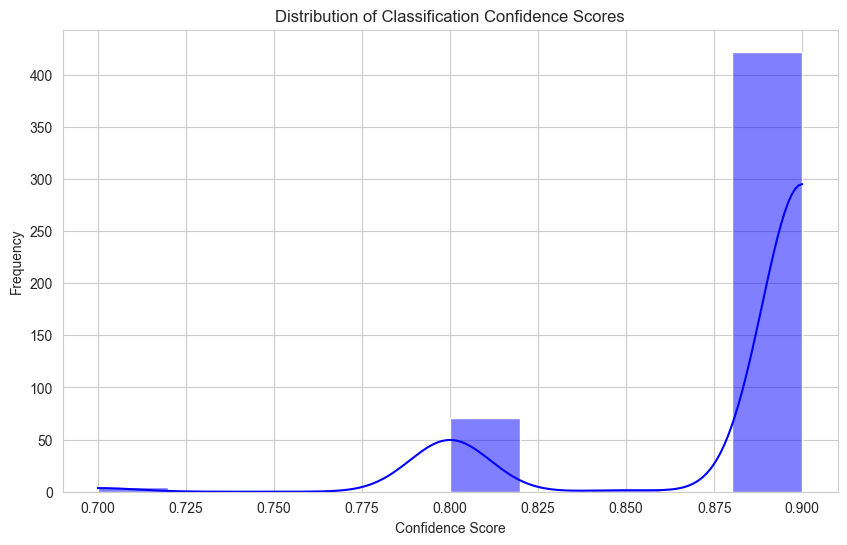

In [17]:
# Assuming 'Classification' is a column containing LanguageClassification objects
# Extract the confidence scores from the Classification column
confidence_scores = subset['Classification'].apply(lambda x: x.confidence)

# Count observations based on confidence levels
above_0_9 = (confidence_scores > 0.9).sum()
between_0_6_and_0_9 = ((confidence_scores >= 0.6) & (confidence_scores <= 0.9)).sum()
below_0_6 = (confidence_scores < 0.6).sum()

# Print the results
print(f"Observations with confidence above 0.9: {above_0_9}")
print(f"Observations with confidence between 0.6 and 0.9: {between_0_6_and_0_9}")
print(f"Observations with confidence below 0.6: {below_0_6}")

# Plotting the distribution of confidence scores using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the distribution of confidence scores
sns.histplot(confidence_scores, kde=True, ax=ax, color='blue')

# Setting the title and labels
ax.set_title('Distribution of Classification Confidence Scores')
ax.set_xlabel('Confidence Score')
ax.set_ylabel('Frequency')

# Displaying the plot
plt.show()

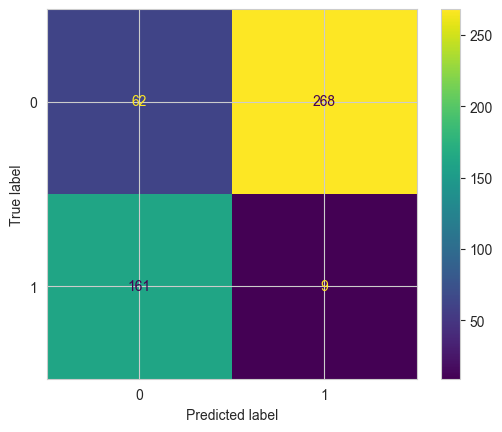

In [18]:
# Show a confusion matrix of our binary classification
# The real Y is Email Type, and the predicted Y is Email Classification


from sklearn.metrics import confusion_matrix
confusion_matrix(subset['News Classification'], subset['label'])

# Have a plot or visualization of the confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(subset['News Classification'], subset['label'])



### Traditional Machine Learning Classification


In [19]:
subset


,Unnamed: 0,title,text,label,title_word_count,title_char_count,text_word_count,text_char_count,title_full_cap_words,text_full_cap_words,text_first_five_words_with_parentheses,article,Classification,News Classification
0,0,"Live from New York, it's a Trump-Clinton remat...",NEW YORK (Reuters) - Veteran actor and frequen...,1,11,59,363,2221,0,14,True,"title: Live from New York, it's a Trump-Clinto...",category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
1,1,Catalan separatists to lose majority in tight ...,BARCELONA (Reuters) - Catalonia s independence...,1,9,60,210,1281,0,2,True,title: Catalan separatists to lose majority in...,category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
2,2,North Carolina governor concedes election to D...,"WINSTON-SALEM, N.C. (Reuters) - North Carolina...",1,8,64,417,2621,0,7,True,title: North Carolina governor concedes electi...,category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
3,3,Draft Senate Iran legislation sets tough new U...,WASHINGTON (Reuters) - Draft legislation respo...,1,11,64,410,2542,1,4,True,title: Draft Senate Iran legislation sets toug...,category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
4,4,California governor taps U.S. Representative B...,"SACRAMENTO, Calif. (Reuters) - California Gove...",1,9,72,463,3055,1,8,True,title: California governor taps U.S. Represent...,category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,Red Cross says life has stopped in Myanmar's R...,GENEVA (Reuters) - Life has stopped in its tra...,1,9,52,484,2944,0,8,True,title: Red Cross says life has stopped in Myan...,category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
496,496,"In One Chart, This Company Schooled Donald Tr...","Donald Trump, at 71 years old, apparently just...",0,13,71,335,2135,0,10,False,"title: In One Chart, This Company Schooled Do...",category=<FakeNewsCategory.FAKE_NEWS: 'fake_ne...,1
497,497,EU leaders likely to give go-ahead to new phas...,PARIS (Reuters) - The leaders of the European ...,1,12,63,97,557,1,3,True,title: EU leaders likely to give go-ahead to n...,category=<FakeNewsCategory.REAL_NEWS: 'real_ne...,0
498,498,BOMBSHELL REPORT Proves Trump Right On Illegal...,"According to a nationwide poll, as many as 2 m...",0,8,53,249,1533,2,5,False,title: BOMBSHELL REPORT Proves Trump Right On ...,category=<FakeNewsCategory.FAKE_NEWS: 'fake_ne...,1


Accuracy on the test set: 0.9600


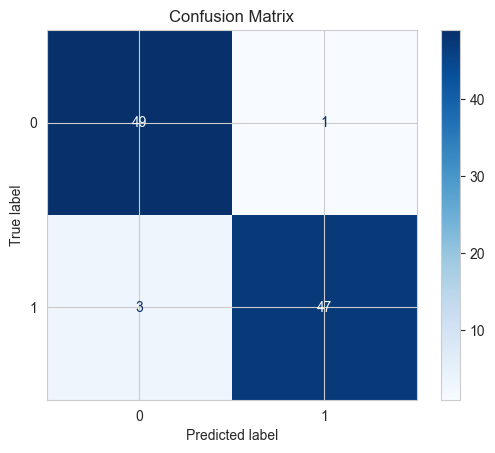

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Assuming 'subset' is your DataFrame
# Drop the specified columns
X = subset.drop(columns=['title', 'text', 'label', 'article', 'Classification', 'News Classification'])
y = subset['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model with regularization
model = LogisticRegression(solver='liblinear')  # 'liblinear' is good for small datasets
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.4f}")

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

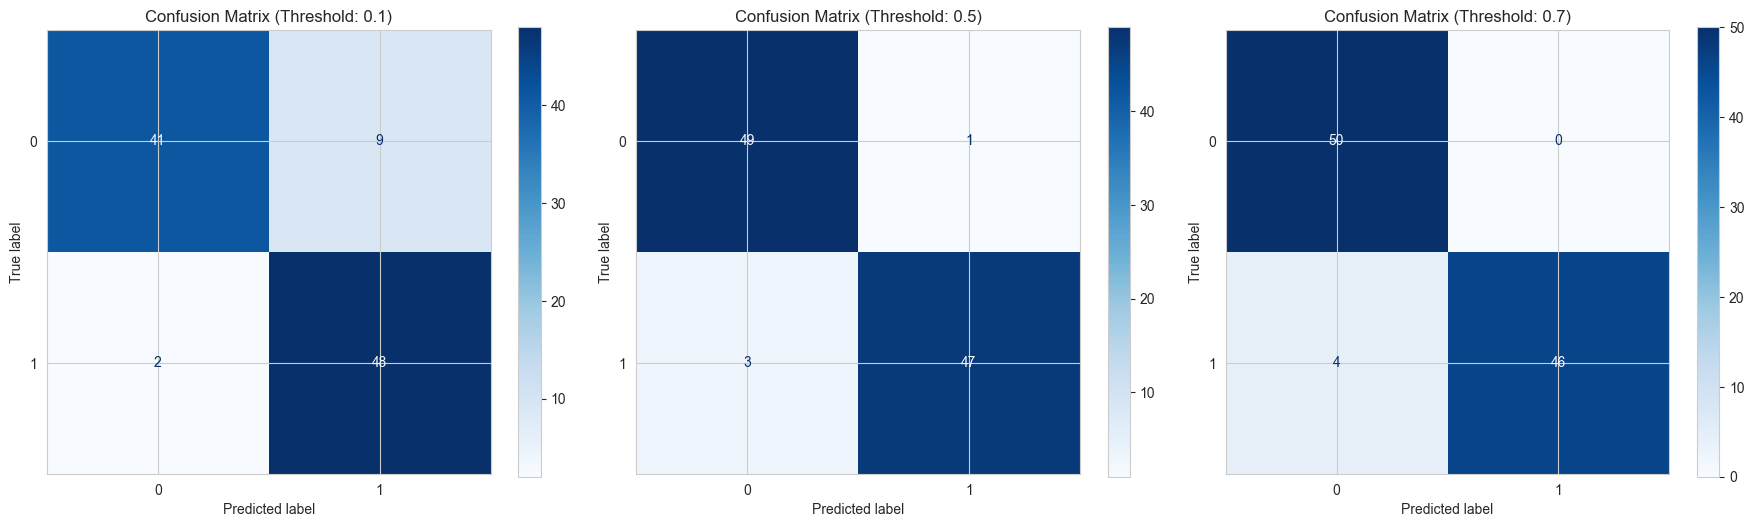

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming 'subset' is your DataFrame
# Drop the specified columns
X = subset.drop(columns=['title', 'text', 'label', 'article', 'Classification', 'News Classification'])
y = subset['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model with regularization
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Predict probabilities on the test set
y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Define thresholds
thresholds = [0.1, 0.5, 0.7]
predictions = {}

# Generate predictions for each threshold
for threshold in thresholds:
    predictions[threshold] = (y_proba >= threshold).astype(int)

# Display confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, threshold in enumerate(thresholds):
    cm = confusion_matrix(y_test, predictions[threshold])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(f'Confusion Matrix (Threshold: {threshold})')

plt.tight_layout()
plt.show()